/Users/yuhangya/Library/Python/3.8/lib/python/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


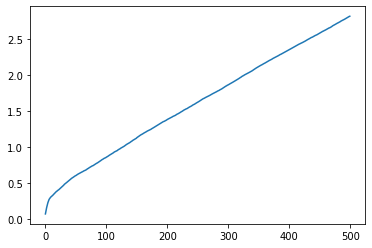

In [1]:
# hard constraints

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

N = 1
T = 500
m = 20  # number of devices
n = 5  # number of servers
y_max = 110
y_min = 90
rs = 0.1
beta = np.ones(n)
beta[0] = 3
beta[1] = 3
seed = 0
np.random.seed(seed)

def optimization(m, n, wS, y, mu, BS, beta, CD):
    x = cp.Variable((n + 1, m), nonneg=True)
    obj = beta @ cp.inv_pos(cp.sqrt(x[1:, :] @ y + wS))

    constraints = [0 <= x, x <= 1,
                   x[1:, :] @ y <= BS,
                   cp.sum(x, 0) == 1]
    for i in range(m):
        constraints.append((y[i] * mu[i, :] @ x[1:, i]) <= CD[i])

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()  # Returns the optimal value.
    return x, prob

def oracle(y, mu):
    x, prob = optimization(m, n, wS, y, mu, BS, beta, CD)
    return x.value, prob.value, prob.status

def f(x, y):
    return beta.dot(1/np.sqrt(x[1:, :].dot(y) + wS))

def f_drop(x, y, mu, CD, BS):
    yp = np.minimum(y, CD/ np.diag(mu @ x[1:, :]))
    dp = np.minimum(x[1:, :].dot(yp), BS)
    return beta.dot(1/np.sqrt(dp + wS))

reg = np.zeros((N, T))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
j_N_T = np.zeros((N, T, m))#yuhang yao
BS_N = np.zeros((N, n))#yuhang yao

for u in range(N):
    wS = np.random.randint(15, 25, n)
    
#     BS = np.random.uniform(y_min*5, y_max*5, n)
#     CD = np.random.uniform(y_min/2, y_max/2, m)
    BS = np.random.uniform(y_min*10, y_max*10, n)
    BS_N[u] = BS
    CD = np.random.uniform(y_min*0.7, y_max*0.7, m)
    mu = np.random.rand(m, n)
    mu[:,0] = 0.5
    mu[:,1] = 0.5
    mu[:,2] = 0.8
    mu[:,3] = 0.8
    mu[:,4] = 0.8
    # trace_gen = Trace(m, n, seed + u)
    # mu = trace_gen.avg()
    # mu = np.random.rand(m, n)
    # mu_hat = np.zeros_like(mu)  # empirical mean
    mu_hat = np.ones_like(mu)
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(y_min, y_max, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu)
        if 'optimal' not in status:
            print('Solution infeasible 1')
            break

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.maximum(mu_hat - rho_ij, 0) # LCB
        x_tmp, f_tmp, status = oracle(y, mu_bar)
        if 'optimal' not in status:
            print('Solution infeasible 2')
            break
        
        # mapping from x_tmp to x_t (new)
        x_t = np.zeros((n + 1, m))
        
        for i in range(m):
            cost = y[i] * mu[i,:].dot(x_tmp[1:, i])
            if cost > CD[i]:
                x_t[1:, i] = mu_bar[i] / mu[i] * x_tmp[1:, i]
                x_t[0, i] = 1-np.sum(x_t[1:, i])
                if x_t[0, i] < 0:
                    x_t[0, i] = 0
                    x_t[1:, i] = x_t[1:, i]/np.sum(x_t[1:, i])
            else:
                x_t[:, i] = x_tmp[:, i]

        f_t = f(x_t, y)
        
        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        # c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:, i])
            j_N_T[u, t, i] = j #yuhang yao
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i, j])
                # a = np.random.rand() * 3
                # c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i, j]  # trace
                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        
plt.plot(np.cumsum(reg, axis=1).T)

In [2]:

np.save("hard_wS", wS)
np.save("hard_BS_N", BS_N)
np.save("hard_y_N_T", y_N_T)
np.save("hard_x_opt_N_T", x_opt_N_T)
np.save("hard_x_t_N_T", x_t_N_T)
np.save("hard_j_N_T", j_N_T)

In [3]:
from functions import *
wS = np.load("hard_wS.npy")
y_N_T = np.load("hard_y_N_T.npy")
x_opt_N_T = np.load("hard_x_opt_N_T.npy")
x_t_N_T = np.load("hard_x_t_N_T.npy")
j_N_T = np.load("hard_j_N_T.npy")
BS_N = np.load("hard_BS_N.npy")




In [4]:

wS = wS.astype(int)
BS_N = BS_N.astype(int)
y_N_T = y_N_T.astype(int)

j_N_T = j_N_T.astype(int)

In [5]:
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        for i in range(m):
            
                    j = j_N_T[u, t, i]#np.random.choice(n + 1, p=x_t_N_T[u, t, :, i])
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                        Data_num_S_N_T[u, t, j] = min(Data_num_S_N_T[u, t, j], BS_N[u, j])


from fed_train import fed_T
import time
save_time = str(time.time())
import torch
torch.manual_seed(seed)
np.random.seed(seed)

total_loss_train = []
total_accuracy_train = []

total_acc_test = []
total_loss_test = []

for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, accuracy_train, acc_tests, loss_tests, args = fed_T(L_T, "mnist", False)
    if len(total_loss_train) == 0:
        total_loss_train = np.array(loss_train)
    else:
        total_loss_train += np.array(loss_train)
        
    if len(total_accuracy_train) == 0:
        total_accuracy_train = np.array(accuracy_train)
    else:
        total_accuracy_train += np.array(accuracy_train)
        
        
    if len(total_acc_test) == 0:
        total_acc_test = np.array(acc_tests)
    else:
        total_acc_test += np.array(acc_tests)
    
    if len(total_loss_test) == 0:
        total_loss_test = np.array(loss_tests)
    else:
        total_loss_test += np.array(loss_tests)

    
total_loss_train /= N
total_accuracy_train /= N
total_acc_test /= N
total_loss_test /= N

np.save("hard_iid" + str(args.iid) + "total_loss_train", total_loss_train)
np.save("hard_iid" + str(args.iid) + "total_accuracy_train", total_accuracy_train)
np.save("hard_iid" + str(args.iid) + "total_acc_test", total_acc_test)
np.save("hard_iid" + str(args.iid) + "total_loss_test", total_loss_test)


/Users/yuhangya/Library/Python/3.8/lib/python/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/Users/yuhangya/Library/Python/3.8/lib/python/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=10, bias=True)
)
Round   0, Average Train loss 2.113, Average Train Accuracy 30.649
Testing accuracy: 19.76
Testing loss: 2.22
Round   1, Average Train loss 1.996, Average Train Accuracy 37.928
Testing accuracy: 27.04
Testing loss: 2.16
Round   2, Average Train loss 1.929, Average Train Accuracy 43.572
Testing accuracy: 24.93
Testing loss: 2.10
Round   3, Average Train loss 1.816, Average Train Accuracy 49.796
Testing accuracy: 28.92
Testing loss: 2.04
Round   4, Average Train loss 1.737, Average Train Accuracy 52.496
Testing accuracy: 27.99
Testing loss: 1.99
Round   5, Average Train loss 1.663, Average Train Accuracy 53.856
Testing accuracy: 32.08
Testing loss: 1.94
Round   6, Average Train loss 1.582, Average Train Accuracy 57.320
Testing accuracy: 33.92
Testing loss: 1.89
Round   7, Average Trai

Testing accuracy: 82.84
Testing loss: 0.59
Round  73, Average Train loss 0.554, Average Train Accuracy 85.137
Testing accuracy: 81.10
Testing loss: 0.60
Round  74, Average Train loss 0.525, Average Train Accuracy 85.509
Testing accuracy: 81.40
Testing loss: 0.59
Round  75, Average Train loss 0.540, Average Train Accuracy 85.244
Testing accuracy: 81.25
Testing loss: 0.59
Round  76, Average Train loss 0.512, Average Train Accuracy 85.957
Testing accuracy: 82.20
Testing loss: 0.58
Round  77, Average Train loss 0.551, Average Train Accuracy 84.923
Testing accuracy: 82.95
Testing loss: 0.57
Round  78, Average Train loss 0.523, Average Train Accuracy 85.934
Testing accuracy: 83.50
Testing loss: 0.56
Round  79, Average Train loss 0.532, Average Train Accuracy 85.437
Testing accuracy: 84.88
Testing loss: 0.55
Round  80, Average Train loss 0.535, Average Train Accuracy 85.336
Testing accuracy: 85.16
Testing loss: 0.55
Round  81, Average Train loss 0.510, Average Train Accuracy 87.245
Testing ac

Testing accuracy: 84.98
Testing loss: 0.47
Round 148, Average Train loss 0.410, Average Train Accuracy 88.468
Testing accuracy: 86.88
Testing loss: 0.44
Round 149, Average Train loss 0.400, Average Train Accuracy 89.246
Testing accuracy: 86.71
Testing loss: 0.45
Round 150, Average Train loss 0.421, Average Train Accuracy 88.016
Testing accuracy: 85.95
Testing loss: 0.46
Round 151, Average Train loss 0.427, Average Train Accuracy 88.013
Testing accuracy: 86.54
Testing loss: 0.45
Round 152, Average Train loss 0.392, Average Train Accuracy 88.469
Testing accuracy: 87.36
Testing loss: 0.43
Round 153, Average Train loss 0.401, Average Train Accuracy 88.695
Testing accuracy: 87.46
Testing loss: 0.43
Round 154, Average Train loss 0.420, Average Train Accuracy 87.519
Testing accuracy: 87.07
Testing loss: 0.43
Round 155, Average Train loss 0.381, Average Train Accuracy 88.709
Testing accuracy: 86.91
Testing loss: 0.44
Round 156, Average Train loss 0.379, Average Train Accuracy 89.334
Testing ac

Testing accuracy: 88.57
Testing loss: 0.38
Round 223, Average Train loss 0.355, Average Train Accuracy 89.148
Testing accuracy: 88.86
Testing loss: 0.38
Round 224, Average Train loss 0.345, Average Train Accuracy 90.314
Testing accuracy: 88.49
Testing loss: 0.38
Round 225, Average Train loss 0.342, Average Train Accuracy 89.787
Testing accuracy: 88.68
Testing loss: 0.38
Round 226, Average Train loss 0.364, Average Train Accuracy 89.126
Testing accuracy: 88.80
Testing loss: 0.38
Round 227, Average Train loss 0.363, Average Train Accuracy 88.939
Testing accuracy: 88.90
Testing loss: 0.37
Round 228, Average Train loss 0.332, Average Train Accuracy 90.987
Testing accuracy: 89.14
Testing loss: 0.37
Round 229, Average Train loss 0.353, Average Train Accuracy 89.986
Testing accuracy: 88.91
Testing loss: 0.37
Round 230, Average Train loss 0.353, Average Train Accuracy 89.887
Testing accuracy: 88.67
Testing loss: 0.38
Round 231, Average Train loss 0.354, Average Train Accuracy 89.391
Testing ac

Testing accuracy: 88.73
Testing loss: 0.37
Round 298, Average Train loss 0.326, Average Train Accuracy 90.889
Testing accuracy: 88.97
Testing loss: 0.36
Round 299, Average Train loss 0.295, Average Train Accuracy 91.981
Testing accuracy: 89.61
Testing loss: 0.35
Round 300, Average Train loss 0.320, Average Train Accuracy 90.733
Testing accuracy: 89.10
Testing loss: 0.36
Round 301, Average Train loss 0.307, Average Train Accuracy 90.569
Testing accuracy: 89.15
Testing loss: 0.36
Round 302, Average Train loss 0.335, Average Train Accuracy 89.907
Testing accuracy: 89.31
Testing loss: 0.35
Round 303, Average Train loss 0.316, Average Train Accuracy 91.080
Testing accuracy: 89.15
Testing loss: 0.35
Round 304, Average Train loss 0.309, Average Train Accuracy 91.246
Testing accuracy: 89.07
Testing loss: 0.35
Round 305, Average Train loss 0.318, Average Train Accuracy 89.990
Testing accuracy: 89.50
Testing loss: 0.34
Round 306, Average Train loss 0.325, Average Train Accuracy 90.537
Testing ac

Testing accuracy: 90.73
Testing loss: 0.32
Round 373, Average Train loss 0.298, Average Train Accuracy 91.076
Testing accuracy: 90.61
Testing loss: 0.32
Round 374, Average Train loss 0.309, Average Train Accuracy 90.832
Testing accuracy: 90.61
Testing loss: 0.32
Round 375, Average Train loss 0.281, Average Train Accuracy 91.725
Testing accuracy: 90.32
Testing loss: 0.32
Round 376, Average Train loss 0.276, Average Train Accuracy 91.955
Testing accuracy: 90.08
Testing loss: 0.33
Round 377, Average Train loss 0.300, Average Train Accuracy 91.142
Testing accuracy: 90.27
Testing loss: 0.32
Round 378, Average Train loss 0.285, Average Train Accuracy 91.367
Testing accuracy: 90.32
Testing loss: 0.32
Round 379, Average Train loss 0.299, Average Train Accuracy 91.442
Testing accuracy: 90.59
Testing loss: 0.32
Round 380, Average Train loss 0.283, Average Train Accuracy 92.395
Testing accuracy: 90.56
Testing loss: 0.32
Round 381, Average Train loss 0.275, Average Train Accuracy 92.975
Testing ac

Testing accuracy: 90.49
Testing loss: 0.31
Round 448, Average Train loss 0.263, Average Train Accuracy 92.585
Testing accuracy: 90.63
Testing loss: 0.31
Round 449, Average Train loss 0.243, Average Train Accuracy 92.627
Testing accuracy: 90.76
Testing loss: 0.31
Round 450, Average Train loss 0.275, Average Train Accuracy 91.858
Testing accuracy: 90.60
Testing loss: 0.31
Round 451, Average Train loss 0.270, Average Train Accuracy 91.893
Testing accuracy: 90.53
Testing loss: 0.31
Round 452, Average Train loss 0.263, Average Train Accuracy 91.820
Testing accuracy: 90.39
Testing loss: 0.31
Round 453, Average Train loss 0.258, Average Train Accuracy 91.921
Testing accuracy: 90.61
Testing loss: 0.31
Round 454, Average Train loss 0.282, Average Train Accuracy 92.006
Testing accuracy: 90.91
Testing loss: 0.30
Round 455, Average Train loss 0.254, Average Train Accuracy 92.754
Testing accuracy: 91.10
Testing loss: 0.30
Round 456, Average Train loss 0.261, Average Train Accuracy 92.584
Testing ac

In [ ]:
torch.manual_seed(seed)
np.random.seed(seed)
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        for i in range(m):
            
                    j = np.random.choice(n + 1)
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                        Data_num_S_N_T[u, t, j] = min(Data_num_S_N_T[u, t, j], BS_N[u, j])


from fed_train import fed_T
import time
save_time = str(time.time())
import torch


total_loss_train = []
total_accuracy_train = []

total_acc_test = []
total_loss_test = []

for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, accuracy_train, acc_tests, loss_tests, args = fed_T(L_T, "mnist", False)
    if len(total_loss_train) == 0:
        total_loss_train = np.array(loss_train)
    else:
        total_loss_train += np.array(loss_train)
        
    if len(total_accuracy_train) == 0:
        total_accuracy_train = np.array(accuracy_train)
    else:
        total_accuracy_train += np.array(accuracy_train)
        
        
    if len(total_acc_test) == 0:
        total_acc_test = np.array(acc_tests)
    else:
        total_acc_test += np.array(acc_tests)
    
    if len(total_loss_test) == 0:
        total_loss_test = np.array(loss_tests)
    else:
        total_loss_test += np.array(loss_tests)

    
total_loss_train /= N
total_accuracy_train /= N
total_acc_test /= N
total_loss_test /= N




np.save("random_hard_iid" + str(args.iid) + "total_loss_train", total_loss_train)
np.save("random_hard_iid" + str(args.iid) + "total_accuracy_train", total_accuracy_train)
np.save("random_hard_iid" + str(args.iid) + "total_acc_test", total_acc_test)
np.save("random_hard_iid" + str(args.iid) + "total_loss_test", total_loss_test)